# Tutorial: Calculating Population Dynamics and Absorbance Spectra with HEOM

This tutorial illustrates how to set up parameters and call the heom function to calculate population dyanmics, constuct absorbance spectra using other Libra functions, and visualize the results. 

## Table of Contents
<a name="toc"></a>
1. [Population and coherence dynamics](#Pop_dynamics)
2. [Absorbance lineshape calculations](#Lineshapes)    
    2.1 [Define population dynamics parameters](#Lineshapes_1)   
    2.2 [Compute the ACF](#Lineshapes_2)   
    2.3 [Fourier transform the ACF](#Lineshapes_3) 
    
### A. Learning objectives

- to be able to compute the population/coherence dynamics of a quantum system embedded in a bath
- to be able to compute absorption spectra lineshapes of a quantum system embedded in a bath
- to be able to read the output and visualize results

### B. Use cases
- [compute population dynamics of a quantum system embedded in a bath](#Pop_dynamics)
- [compute coherences of a quantum system embedded in a bath](#Pop_dynamics)
- [compute absorbance spectal lineshapes of a quantum system embedded in a bath](#Lineshapes) 

### C. Functions
- `libra.py`
  - `dynamics`
    - `heom`
      - `compute`
        - [`run_dynamics`](#Pop_dynamics)
        
  - `ft`
    - [`ft2`](#Lineshapes_3)

In [1]:
import cmath
import sys
import cmath
import math
import os
import h5py

import numpy as np
import matplotlib.pyplot as plt

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn
from libra_py import units
import libra_py.dynamics.heom.compute as compute
from libra_py import ft


plt.rc('axes', titlesize=38)      # fontsize of the axes title
plt.rc('axes', labelsize=38)      # fontsize of the x and y labels
plt.rc('legend', fontsize=38)     # legend fontsize
plt.rc('xtick', labelsize=38)    # fontsize of the tick labels
plt.rc('ytick', labelsize=38)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/import

## 1. Population and coherence dynamics <a name="Pop_dynamics"></a>
[Return to Table of contents](#toc)

This example uses a simple two state system to demonstrate the basics of defining parameters and calling the `run_dynamics` funtion. The following defines some of the parameters that go into the `params` dictionary argument, as well as the `Ham` and `rho` matrix arguments. 

Keys in the `params` dictionary:

* `"KK"`- Defines the the number of Matsubara modes (KK+1) - one needs to achieve a convergence w.r.t. this parameter.   
* `"LL"`- The hierarchy level - one needs to achieve a convergence w.r.t. this parameter
* `"gamma"`- The system-bath interaction ("collision") frequency, related to the bath's "friction" on the system  
* `"eta"`- Reorganization energy of bath   
* `"temperature"`- Temperature of the bath
* `"el_phon_couplings"`- The matrices that describe how each electronic phonon is coupled to various electronic states 
* `"dt"`- Time-integration timestep
* `"nsteps"`- How many steps of the dynamics to perform 
* `"truncation_scheme"`- How to truncate the HEOM equations. Options are:
                - 0 : no truncation
                - 1 : according to Schulten, with real part of Matsubara terms
                - 2 : according to Schulten, but with full Matsubara terms
                - 3 : according to Shi, with real part of Matsubara terms
                - 4 : according to Shi, but with full Matsubara terms
* `"do_scale"`- Whether to use the scaled HEOM version. Options are:     
                - 0 : don't use the scaled HEOM
                - 1 : use it according to JCP 130, 084105, 2009    
* `"tolerance"`-The threshold for discarding the auxiliary density matrices. The larger it is, the fewer auxiliary density matrices survives in the HEOM and the faster the calculations become.   
* `"filter_after_steps"`- Denfines the frequency (after how may steps of the dynamics) the auxiliary density matrices will be checked to be potentially discarded (based on the `tolerance` parameter set above)    
* `"num_threads"`- The number of OMP threads to use to parallelize the calculations
    
* `"prefix"`- The name of the folder which will contain the results computed. This folder will be created if not existent already   
\
Additional arguments for `run_dynamics`:
* `Ham`- Define the system's electronic Hamiltonian. The diagonal elements contain the site energies, the off-diagonal elements contain electronic couplings         
* `rho`- Is the initial density matrix describing the quantum system. It's dimensions must be the same as those of the `Ham` variable.

In [2]:
# Hamiltonian
Ham = CMATRIX(2,2)
Ham.set(0, 0, 50);  Ham.set(0, 1, 200);
Ham.set(1, 0, 200);   Ham.set(1, 1, -50)
Ham.scale(-1,-1, units.inv_cm2Ha*(1.0+0.0j))

# Initial density matrix
rho = CMATRIX(2,2); rho.set(0, 0, 1.0+0.0j) # starting state = initial state

# Parameters
params = { # hierarchy parameters
           "KK":0, "LL":1,
    
          # bath parameters
           "gamma": 1/(0.1 * units.ps2au),
           "eta": 2.0 * 50.0 * units.inv_cm2Ha,
           "temperature": 300.0,
           "el_phon_couplings":initialize_el_phonon_couplings(2),

          # dynamics parameters
           "dt":0.1*units.fs2au, "nsteps":10000,
           "verbosity":-1, "progress_frequency":0.1,

          # computational efficiency parameters
           "truncation_scheme":4,
           #"truncation_scheme":0,1,2,3
           "do_scale":0,
           #"do_scale":1
           "adm_tolerance":1e-10, "adm_deriv_tolerance":1e-15,
           "filter_after_steps":1,"do_zeroing":1,
           "num_threads":16,

          # data management parameters 
           "prefix":"out_0",
           "hdf5_output_level":0, "txt_output_level":0, "mem_output_level":3,
           "properties_to_save": [ "timestep", "time", "denmat"],
           "use_compression":0, "compression_level":[0,0,0]
         }

# Run the actual calculations
compute.run_dynamics(params, Ham, rho)

 step= 0
 step= 1000
 step= 2000
 step= 3000
 step= 4000
 step= 5000
 step= 6000
 step= 7000
 step= 8000
 step= 9000
Calculations took 37.30109095573425 seconds
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'denmat']
keywords =  ['timestep', 'time', 'denmat']
keys =  dict_keys(['timestep', 'time', 'denmat'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named denmat/data


The output is saved in the location defined by "prefix" in the params dictionary, here `"prefix":"out_0"`. The file is named "mem_data.hdf" as defined in the compute function. The following cell will demonstrate how to read the data from the hdf file and plot the results using matplotlib.  

/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


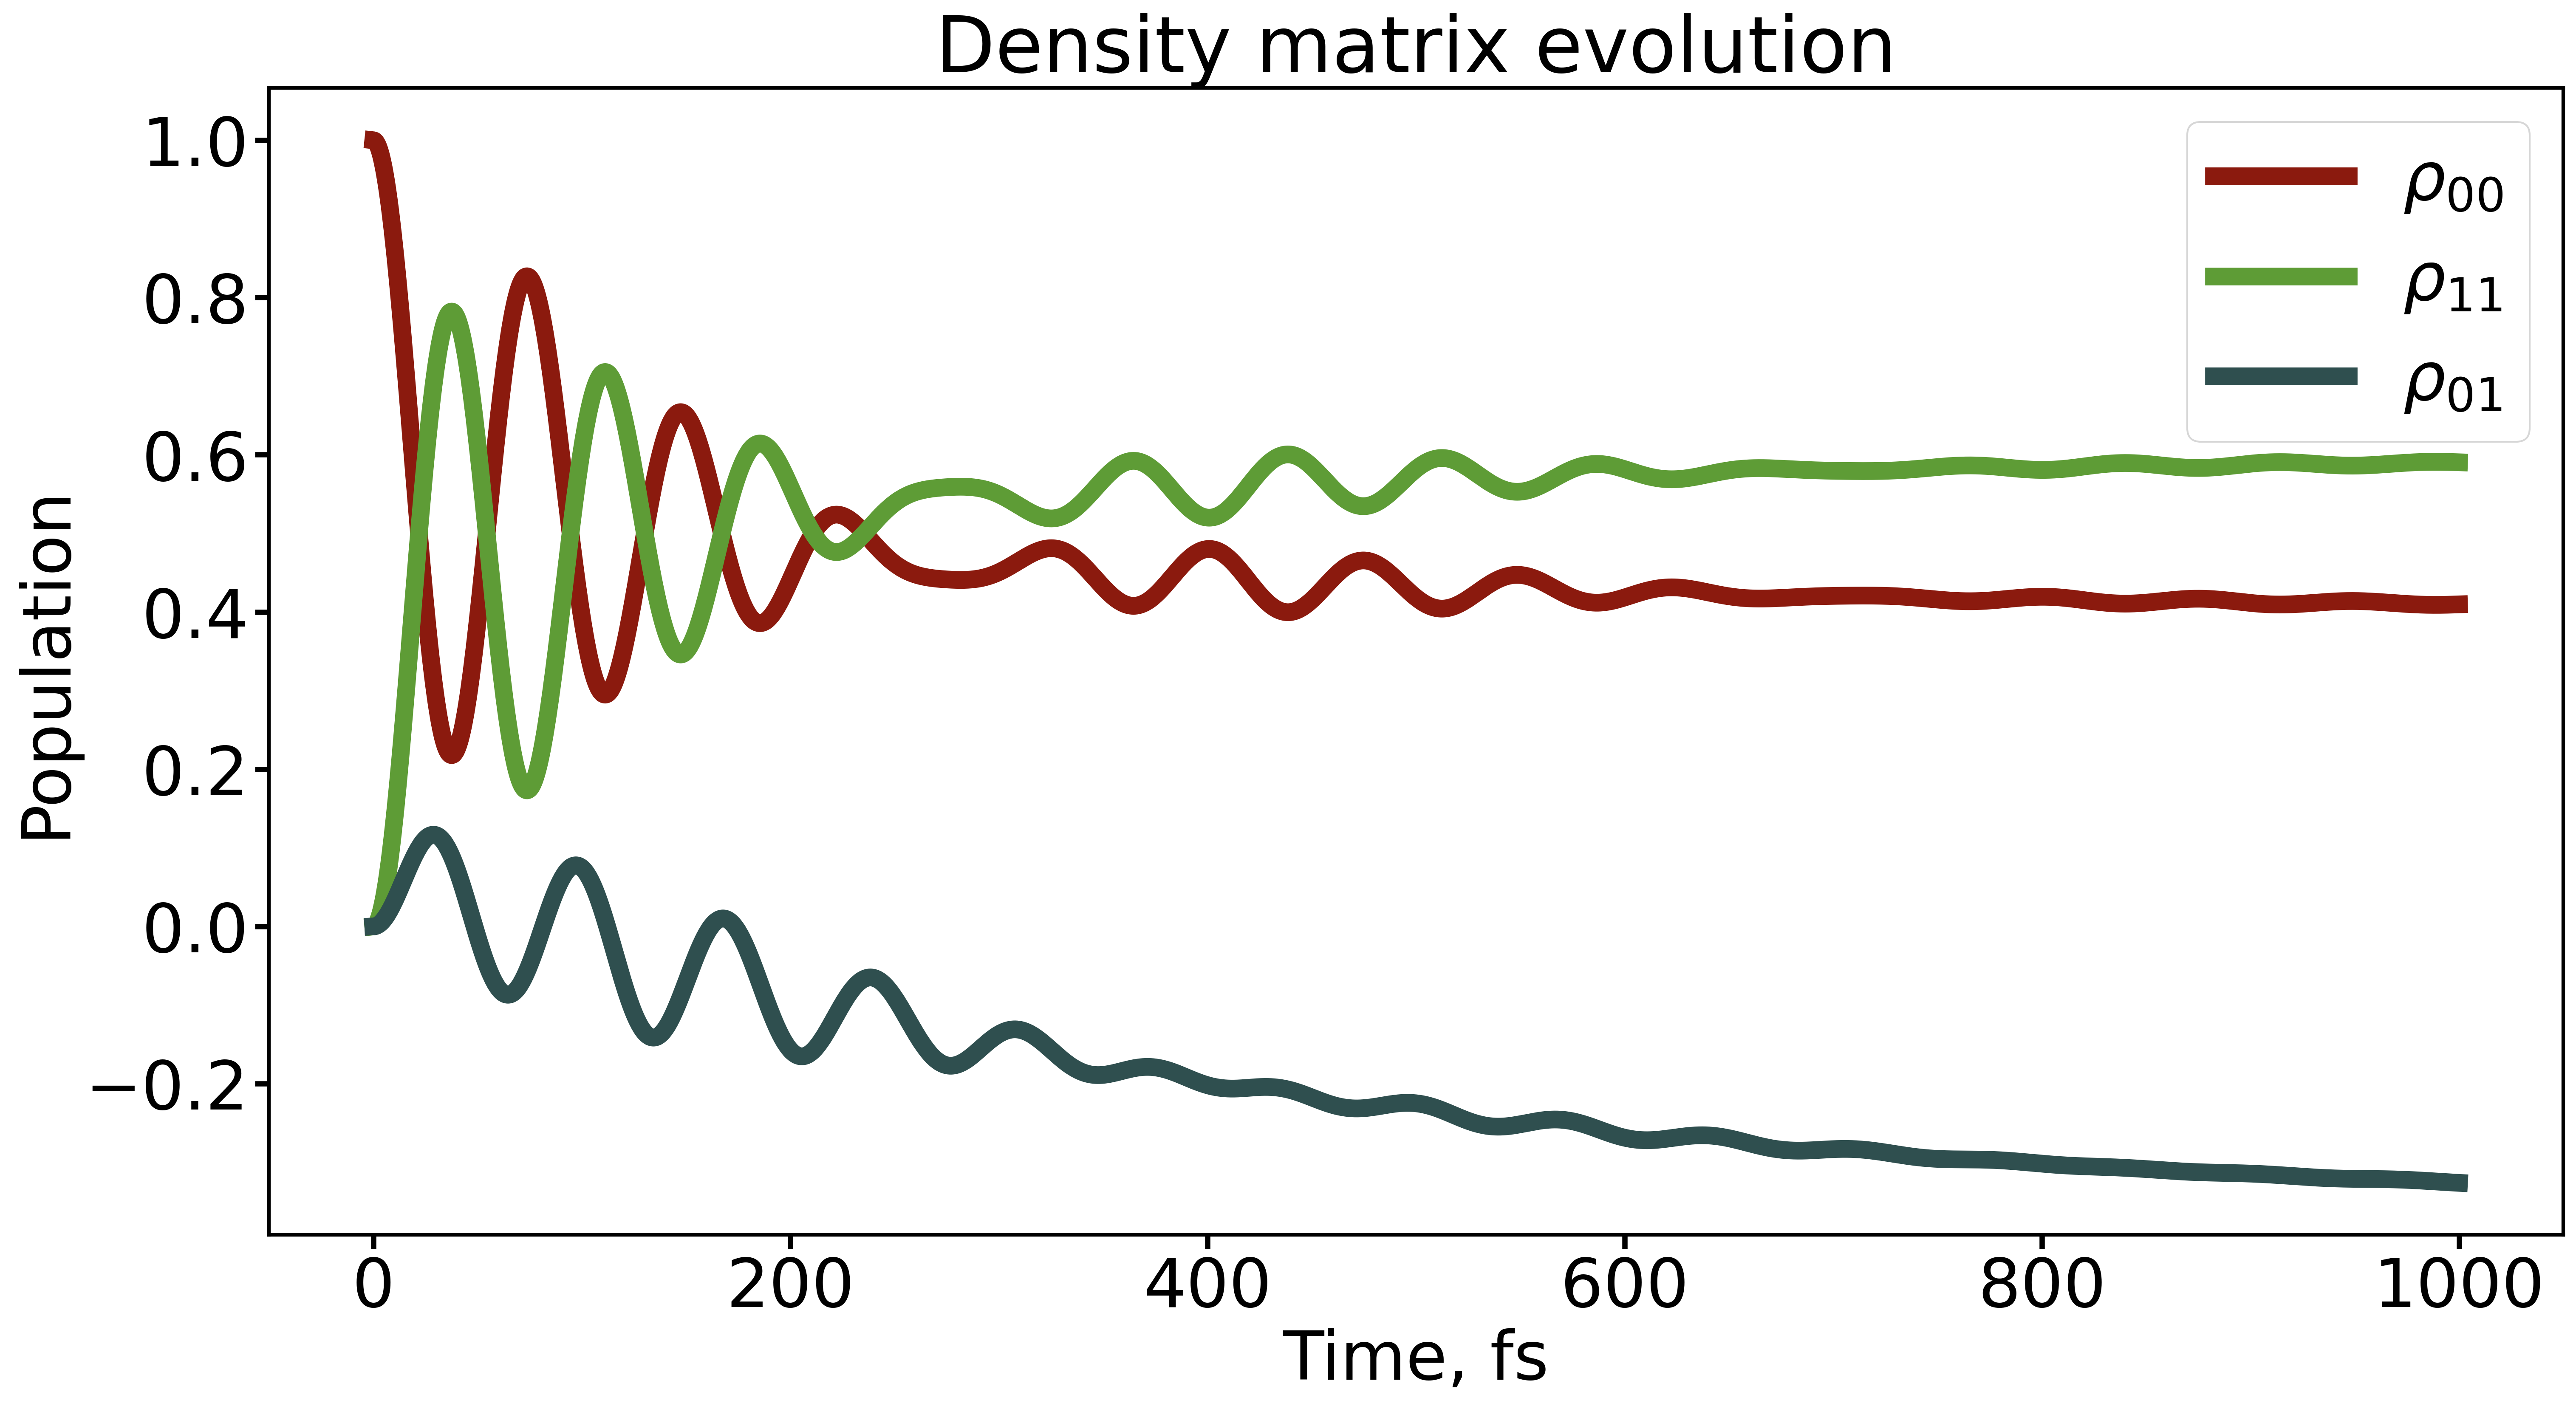

In [3]:
time, pop0, pop1, coherence01 = None, None, None, None

with h5py.File(F"out_0/mem_data.hdf", 'r') as f:
    time = list(f["time/data"][:] * units.au2fs)
    pop0 = list(f["denmat/data"][:, 0,0])
    pop1 = list(f["denmat/data"][:, 1,1])
    coherence01 = list(f["denmat/data"][:, 0,1])
    
plt.figure(1, figsize=(24, 12), dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Density matrix evolution', fontsize=44)
plt.xlabel('Time, fs')
plt.ylabel('Population')
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(length=8, width=3)
plt.plot(time, pop0, label='$\\rho_{00}$', linewidth=10, color = colors["11"]) 
plt.plot(time, pop1, label='$\\rho_{11}$', linewidth=10, color = colors["21"]) 
plt.plot(time, coherence01, label='$\\rho_{01}$', linewidth=10, color = colors["41"]) 
plt.legend()
plt.show()
plt.close()

## 2. Absorption lineshape calculations <a name="Lineshapes"></a>
[Return to Table of contents](#toc)

The next few cells demonstrate how to compute the spectral lineshapes using a three state system as an example. 

First, to be consistent with the published works, it's assumed the excited states aren't coupled to the ground state. 

Second, the transition dipole matrix operator must be defined to compute the ACF of the system's dipole moment operator. Its evolution is determined via the evolution of the density matrix.

Third, the initial conditions are described by the initial ground state wavefunction and evolved according to the transition dipole moment operator. That is we start not with $\rho$, but with $\mu \rho$

This shall be done for two temperatures. 

### 2.1 Define population dynamics parameters<a name="Lineshapes_1"></a>
[Return to Table of contents](#toc)

The system is defined as previously described. The dipole operator is also defined here. An important note is how the initial state is defined as $\mu \rho$, whereas the previous example used $\rho$. 

In [4]:
J = 0.1   # in atomic units
Omega = 1.5*J

# Hamiltonian
Ham = CMATRIX(3,3)

Ham.set(0, 0, Omega*(0.0+0.0j));  Ham.set(0, 1,     J*(0.0+0.0j) );   Ham.set(0, 2,     J*(0.0+0.0j));
Ham.set(1, 0,     J*(0.0+0.0j));  Ham.set(1, 1, Omega*(1.0+0.0j)  );  Ham.set(1, 2,     J*(-1.0+0.0j));
Ham.set(2, 0,     J*(0.0+0.0j));  Ham.set(2, 1,     J*(-1.0+0.0j) );  Ham.set(2, 2, Omega*(1.0+0.0j) );

# Dipole operator
mu = CMATRIX(3,3)
mu.set(0,0, 0.0+0.0j);  mu.set(0,1, 1.0+0.0j);   mu.set(0,2, 1.0+0.0j); 
mu.set(1,0, 1.0+0.0j);  mu.set(1,1, 0.0+0.0j);   mu.set(1,2, 0.0+0.0j); 
mu.set(2,0, 1.0+0.0j);  mu.set(2,1, 0.0+0.0j);   mu.set(2,2, 0.0+0.0j); 

# Initial density matrix
rho = CMATRIX(3,3); rho.set(0, 0, 1.0+0.0j) # starting state
rho = mu * rho  # initial condition - accounts for the initial excitation

# Electron-Phonon couplings as F[m] = |m><m|
Q = CMATRIXList()
Q.append(CMATRIX(3,3)); Q[0].set(0,0, 0.0+0.0j)
Q.append(CMATRIX(3,3)); Q[1].set(1,1, 1.0+0.0j)
Q.append(CMATRIX(3,3)); Q[2].set(2,2, 1.0+0.0j)

# Parameters
params = { "KK":0, "LL":10, "gamma": 0.3*J, "eta": 4.0 * J,
           "temperature": (J/(2.0 * units.kB)), "el_phon_couplings":Q,
           "dt":0.1, "nsteps":1000, "verbosity":-1, "progress_frequency":0.1,
           "truncation_scheme":4, "do_scale":1,
           "adm_tolerance":1e-15, "adm_deriv_tolerance":1e-25,
           "filter_after_steps":1, "do_zeroing":0,
           "num_threads":4,"prefix":"out_spectra_0", 
           "hdf5_output_level":0, "txt_output_level":0, "mem_output_level":3,
           "properties_to_save": [ "timestep", "time", "denmat"],
           "use_compression":0, "compression_level":[0,0,0]
         }

# Run the actual calculations
compute.run_dynamics(params, Ham, rho)

# For another temperature
params.update({"temperature": (J/(5.0 * units.kB)), "prefix":"out_spectra_1"})
compute.run_dynamics(params, Ham, rho)

 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600
 step= 700
 step= 800
 step= 900
Calculations took 9.149319887161255 seconds
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'denmat']
keywords =  ['timestep', 'time', 'denmat']
keys =  dict_keys(['timestep', 'time', 'denmat'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named denmat/data
 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600
 step= 700
 step= 800
 step= 900
Calculations took 8.61441946029663 seconds
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'denmat']
keywords =  ['timestep', 'time', 'denmat']
keys =  dict_keys(['timestep', 'time', 'denmat'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named denmat/data


### 2.2 Compute the ACF <a name="Lineshapes_2"></a>
[Return to Table of contents](#toc)

Using the computed evolution of density matrix (now stored in the file), let's compute the evolution of the dipole moment operator autocorrelation function (ACF).

In [22]:
time = None
acf = [ [], [] ]

for temp_indx in [0, 1]:
    with h5py.File(F"out_spectra_{temp_indx}/mem_data.hdf", 'r') as f:
        time = list(f["time/data"][:] * units.au2fs)       
        nsteps = f["denmat/data"].shape[0]
        
        rho = CMATRIX(3,3)    
        
        for step in range(nsteps):        
            for i in range(f["denmat/data"].shape[1]):
                for j in range(f["denmat/data"].shape[2]):
                    rho.set(i,j, f["denmat/data"][step, i,j])
                
            ct = (mu * rho).tr().imag
            acf[temp_indx].append(ct)
           

Plot the results. 

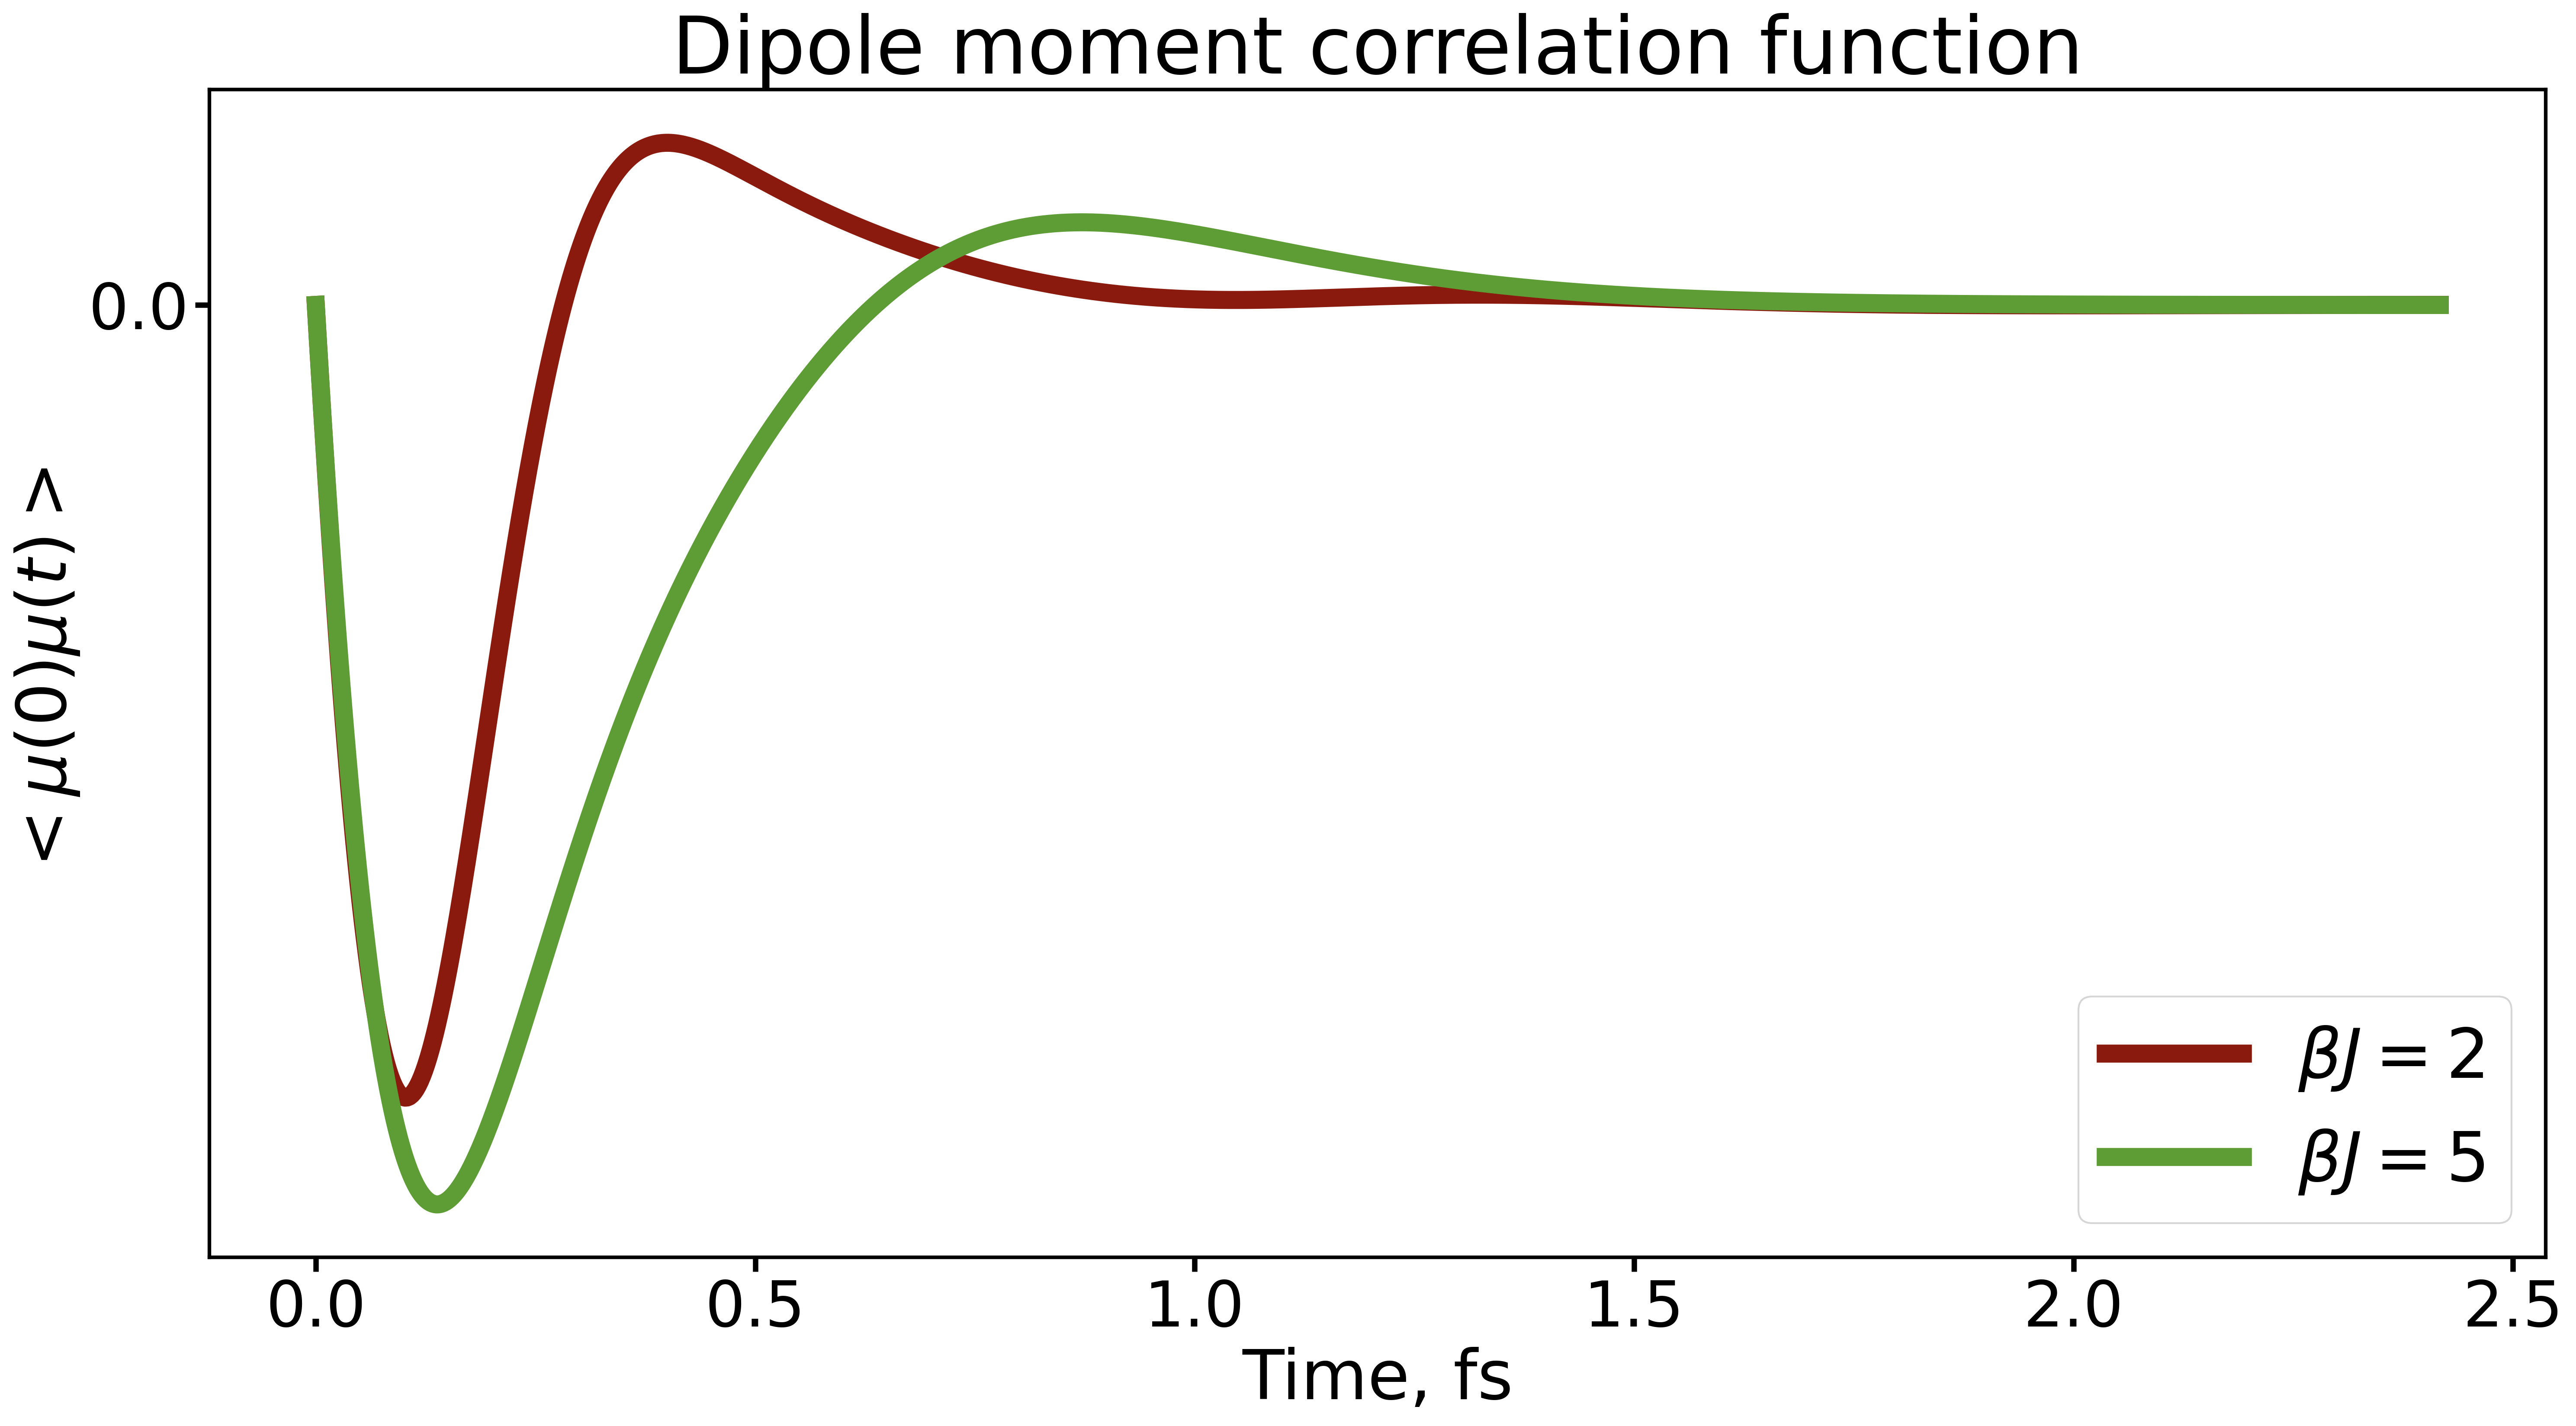

In [23]:
plt.figure(2, figsize=(24, 12), dpi=300, frameon=False)
plt.subplot(1,1,1)
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(length=8, width=3, labelsize=35)
plt.yticks((0, 0.5, 1, 1.5, 2))
plt.title('Dipole moment correlation function', fontsize=44)
plt.xlabel('Time, fs')
plt.ylabel('$<\mu(0) \mu(t)>$')
plt.plot(time, acf[0], label="$\\beta J = 2$", linewidth=10, color = colors["11"]) 
plt.plot(time, acf[1], label="$\\beta J = 5$", linewidth=10, color = colors["21"]) 
plt.legend()
plt.show()
plt.close()

### 2.3 Fourier transform the ACF <a name="Lineshapes_3"></a>
[Return to Table of contents](#toc)

Lastly, we'll do the Fourier transform of the ACF. For this, we use the `ft2` function in `libra_py.ft`. The `ft2` function transforms data from a time domain into frequency space. 

In [15]:
wmin = -6.0*J + Omega
wmax = 4.0*J + Omega
dt = params["dt"]
dw = (wmax-wmin)/(params["nsteps"]) 

W, intensity = None, [[] , [] ]
for temp_indx in [0, 1]:
    W, ampl, I, I2, intensity[temp_indx], ampl_im = \
    ft.ft2(acf[temp_indx], wmin, wmax, dw, dt)

    
    
    
    
    
    
# Normalization of the y axis
for temp_indx in [0, 1]:
    for ind, val in enumerate(intensity[temp_indx]):
        intensity[temp_indx][ind] = 0.5*val/math.pi
    
# Shift and scaling of the x axis
W_shifted = []
for w in W:
    W_shifted.append( (w-Omega)/J )

and print the spectra.

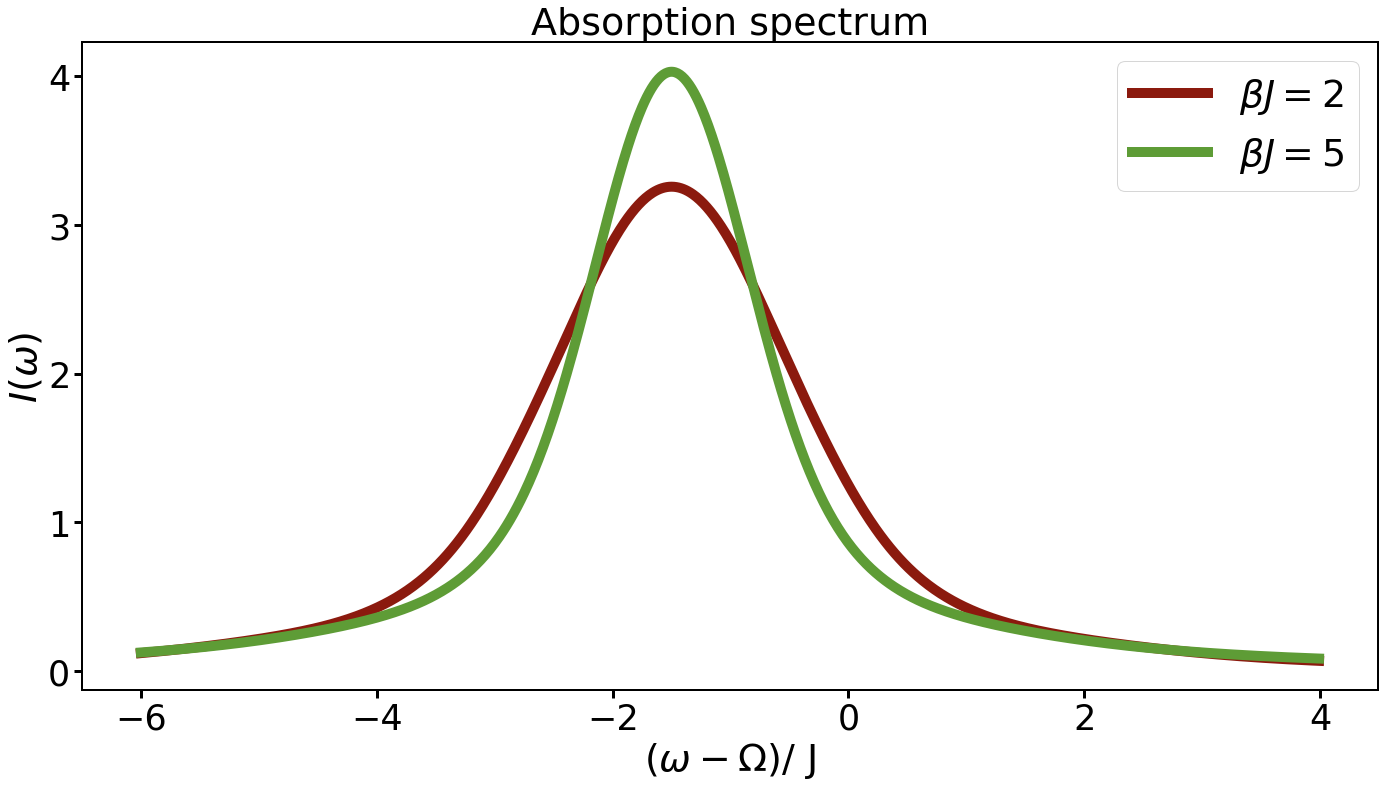

In [16]:
plt.figure(3, figsize=(24, 12)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(length=8, width=3, labelsize=35)
plt.title('Absorption spectrum')
plt.xlabel('$(\omega - \Omega)$/ J')
plt.ylabel('$I(\omega)$')
plt.plot(W_shifted, intensity[0], label="$\\beta J = 2$", linewidth=10, color = colors["11"]) 
plt.plot(W_shifted, intensity[1], label="$\\beta J = 5$", linewidth=10, color = colors["21"]) 
plt.yticks((0, 1, 2, 3, 4))
plt.legend()
plt.show()
plt.close()